# Property insurance risk assessment: 
using public data to estimate building features that affect insurance value


In [99]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, MaxPool2D, Activation, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import random
import os
for dirname, _, filenames in os.walk('D:/1999Faye/自我拓展！/Python/SVM支持向量机'):
    for filename in filenames:
        os.path.join(dirname, filename)
import cv2
from tqdm import tqdm

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')


## Part 1: Self-constructed CNN model

### Define the constant

In [100]:
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

### Pair the image label

<AxesSubplot:>

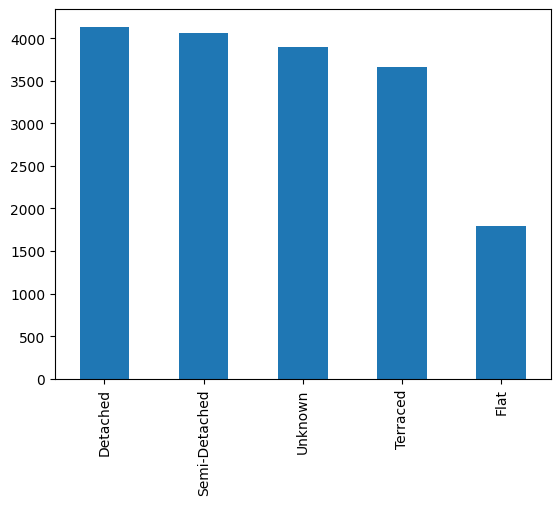

In [101]:
# loading the file name of the image
# filenames = os.listdir("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view")
filenames = os.listdir("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example")
pro = pd.read_csv("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/properties.csv")
pro['property_id'] = 'gsv_' + pro['property_id'] + '.jpg'
pro['propertyType'].value_counts().plot.bar()

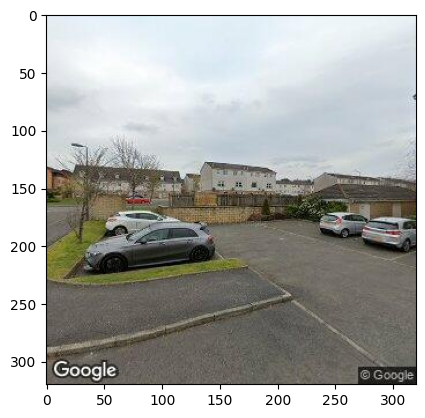

In [102]:
sample = random.choice(filenames)
image = load_img("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/"+sample)
plt.imshow(image)

### Spliting the train and test set

In [103]:
train, test = train_test_split(pro, test_size=0.20, random_state=33)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [104]:
train.head()

,Unnamed: 0,address,propertyType,bedrooms,detailUrl,location_lat,location_lng,property_id
0,0,"Weald Barn House, Wierton Hill, Boughton Monch...",Semi-Detached,4.0,https://www.rightmove.co.uk/house-prices/detai...,51.21990,0.54807,gsv_6f9797e6-917c-428e-a3cb-5a12fa7736b3.jpg
1,0,"Braeside, Langlee, Jedburgh, Roxburghshire TD8...",Unknown,NaN,https://www.rightmove.co.uk/house-prices/detai...,55.45179,-2.56030,gsv_31139028-3fe2-4526-8f7d-40be5d1dc352.jpg
2,0,"40, Noel Gate, Aughton, Ormskirk, Lancashire L...",Semi-Detached,2.0,https://www.rightmove.co.uk/house-prices/detai...,53.55175,-2.91041,gsv_d6b07a47-7c1a-49bb-93ab-be6ac539bb94.jpg
3,0,"42, Windsor Road, Levenshulme, Manchester, Gre...",Semi-Detached,5.0,https://www.rightmove.co.uk/house-prices/detai...,53.44540,-2.19629,gsv_42d66d7e-e5aa-4baf-957f-20339589be28.jpg
4,0,"3, Maesyllan, Llansilin, Oswestry, Powys SY10 7QE",Semi-Detached,NaN,https://www.rightmove.co.uk/house-prices/detai...,52.84316,-3.17405,gsv_f8884edb-6cea-400a-94b7-5d4e14e1eeef.jpg


<AxesSubplot:>

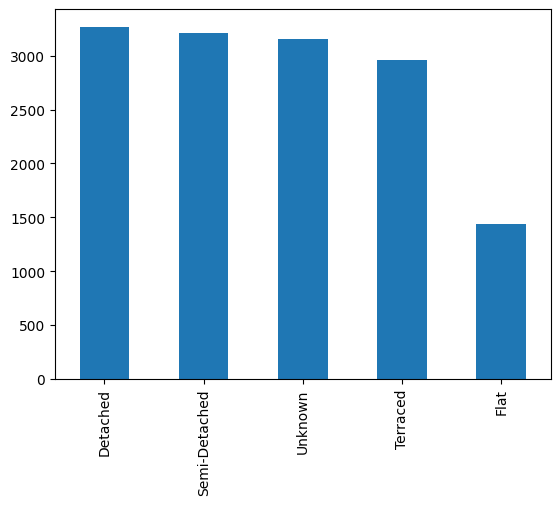

In [105]:
train['propertyType'].value_counts().plot.bar()

<AxesSubplot:>

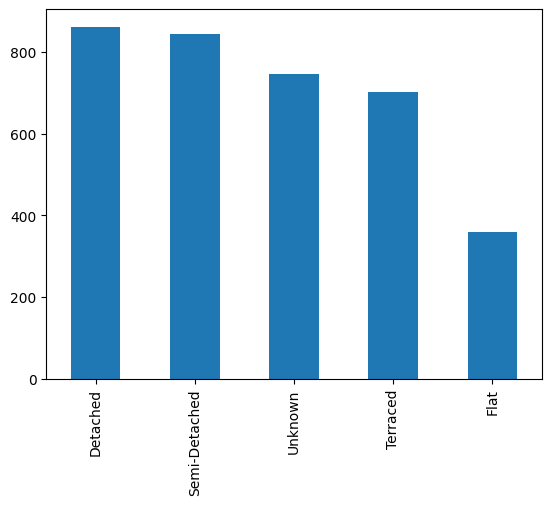

In [106]:
test['propertyType'].value_counts().plot.bar()

In [107]:
train_num = train.shape[0]
test_num = test.shape[0]
# In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples. You may see these values used in models in the literature and in tutorials.
# batch_size=64
batch_size=64
# The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.The number of epochs is traditionally large, often hundreds or thousands, allowing the learning algorithm to run until the error from the model has been sufficiently minimized. You may see examples of the number of epochs in the literature and in tutorials set to 10, 100, 500, 1000, and larger.
# epochs=100
epochs=50

### Building CNN model

In [108]:
model = Sequential()

# Convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 159, 159, 32)     0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 159, 159, 32)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 78, 78, 64)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 78, 78, 64)       

### Prevent over-fitting: callback

In [109]:
# To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

earlystop = EarlyStopping(patience=10)

In [110]:
# We will reduce the learning rate when then accuracy not increase for 3 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.0001)

In [111]:
callbacks = [earlystop, learning_rate_reduction]
# callbacks = [earlystop]

### Image generator

In [112]:
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_imagegenerator = train_idg.flow_from_dataframe(
    train, 
    # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example/", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2034 validated image filenames belonging to 5 classes.


In [113]:
test_idg = ImageDataGenerator(rescale=1./255)
test_imagegenerator = test_idg.flow_from_dataframe(
    test, 
    # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example/", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 516 validated image filenames belonging to 5 classes.


In [19]:
# # example: 

# example_df = train.sample(n=1).reset_index(drop=True)
# example_generator = train_idg.flow_from_dataframe(
#     example_df, 
#     "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
#     x_col='property_id',
#     y_col='propertyType',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical'
# )

In [20]:
# plt.figure(figsize=(12, 12))
# for i in range(0, 15):
#     plt.subplot(5, 3, i+1)
#     for X_batch, Y_batch in example_generator:
#         image = X_batch[0]
#         plt.imshow(image)
#         break
# plt.tight_layout()
# plt.show()

### Fit on the Training set and make predcitons on the Validation set

In [21]:

history = model.fit_generator(
    train_imagegenerator, 
    epochs=epochs,
    validation_data=test_imagegenerator,
    # validation_steps=test_num//batch_size,
    # steps_per_epoch=train_num//batch_size,
    callbacks=callbacks
)




Epoch 1/50
32/32 [==============================] - 146s 4s/step - loss: 3.1439 - accuracy: 0.2301 - val_loss: 1.6040 - val_accuracy: 0.2539 - lr: 0.0010
Epoch 2/50
32/32 [==============================] - 142s 4s/step - loss: 1.5784 - accuracy: 0.2483 - val_loss: 1.5702 - val_accuracy: 0.2771 - lr: 0.0010
Epoch 3/50
32/32 [==============================] - 141s 4s/step - loss: 1.5183 - accuracy: 0.3107 - val_loss: 1.5464 - val_accuracy: 0.2888 - lr: 0.0010
Epoch 4/50
32/32 [==============================] - 143s 4s/step - loss: 1.4848 - accuracy: 0.3235 - val_loss: 1.5525 - val_accuracy: 0.2849 - lr: 0.0010
Epoch 5/50
32/32 [==============================] - 147s 5s/step - loss: 1.4790 - accuracy: 0.3319 - val_loss: 1.5191 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 6/50
32/32 [==============================] - 142s 4s/step - loss: 1.4627 - accuracy: 0.3353 - val_loss: 1.5022 - val_accuracy: 0.3120 - lr: 0.0010
Epoch 7/50
32/32 [==============================] - 141s 4s/step - loss: 1.4

### Visualize the result

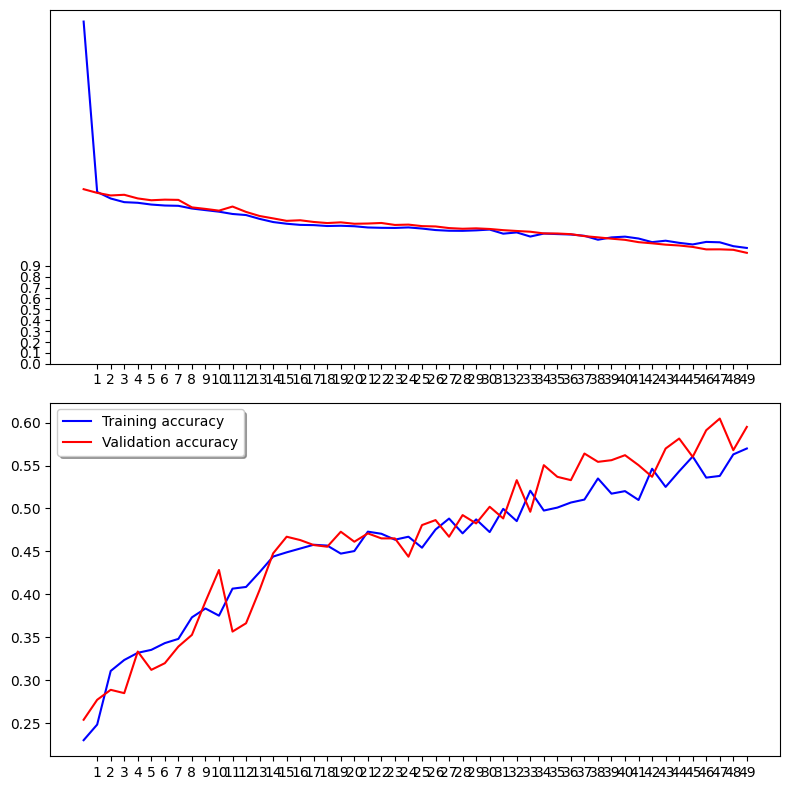

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Part2: 分类是否有房子

手动分类2000多张图片，然后利用SVM将剩下的所有图片分类为【house/not_houst】


#### Building SVM model

SVM algorithm is to be used when their is shortage of data in our dataset

In [114]:
DATADIR = 'D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_svm'
Label = ['house','not_house']

IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

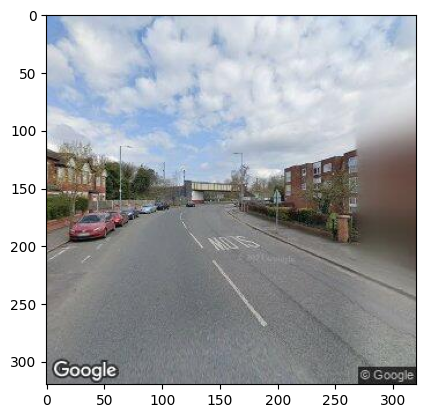

In [115]:
# show a pic
for category in Label:
    path=os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array=load_img(os.path.join(path,img))
        
        
        plt.imshow(img_array)
        # plt.imshow(img_array)
        plt.show()
        
        break
    break

In [116]:
import glob
all_data=[]
for category in Label:
    path=os.path.join(DATADIR, category)
    # img_path = glob.glob(path+'/*.jpg')
    class_num=Label.index(category)
    # for img in img_path:
    for img in os.listdir(path):
        # img_array=cv2.imread(img)
        img_array=cv2.imread(os.path.join(path,img))
        
        all_data.append([img_array,class_num])

img_num = len(all_data)

In [117]:
# X should be of type (training_data_length , -1) because SVM takes 2D input to train 

X=[]
y=[]

for categories, label in all_data:
    X.append(categories)
    y.append(label)
X= np.array(X).reshape(img_num,-1)
##X = tf.keras.utils.normalize(X, axis = 1)

X.shape

(90, 307200)

In [118]:
# flattening the array
X = X/255.0

In [119]:
y=np.array(y)
y.shape

(90,)

split the train and validation data

In [120]:
# applying train_test_split on our data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

fit the model

In [121]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf',gamma='auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [31]:
# use gridsearchcv to automatically choose the parameters for SVM
from sklearn import svm
from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.1,1,10],'gamma':[0.0001,0.001,0.1,1],'kernel':['linear', 'rbf','poly']}
svc=svm.SVC(probability=True)
svm_model=GridSearchCV(svc,param_grid)

svm_model.fit(X_train, y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']})

evaluate the model use validation set

In [32]:
pre_test_y = svm_model.predict(X_test)

from sklearn.metrics import accuracy_score
print("Accuracy on validation set is",accuracy_score(y_test,pre_test_y))

Accuracy on validation set is 0.782608695652174


The accuracy of predicting the house/not_house is around 80% by using SVM. Then try to use CNN to do the image classification. 

#### Building CNN model

In [122]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [123]:
files = os.listdir("D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_cnn/train_label")
label = []
for img in files:
    category = img.split('.')[0]
    if category == 'house':
        label.append('house')
    else:
        label.append('not_house')

df = pd.DataFrame({
    'filename': files,
    'category': label
})

df

,filename,category
0,house.1.jpg,house
1,house.10.jpg,house
2,house.100.jpg,house
3,house.1000.jpg,house
4,house.1001.jpg,house
...,...,...
2545,not_house.95.jpg,not_house
2546,not_house.96.jpg,not_house
2547,not_house.97.jpg,not_house
2548,not_house.98.jpg,not_house


In [124]:
# Use the VGG16 model to do the image classification. 

VGGmodel = Sequential()
VGGmodel.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGGmodel.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
VGGmodel.add(Flatten())
VGGmodel.add(Dense(units=4096, activation="relu"))
VGGmodel.add(Dense(units=4096, activation="relu"))
VGGmodel.add(Dense(units=2, activation="softmax"))

VGGmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
VGGmodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_24 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_26 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [125]:
# Control the training

# checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
# early = EarlyStopping(monitor='val_acc', verbose=1, mode='auto')

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [126]:
train_house, validate_house = train_test_split(df, test_size=0.20, random_state=22)
train_house = train_house.reset_index(drop=True)
validate_house = validate_house.reset_index(drop=True)

num_train = train_house.shape[0]
num_validate = validate_house.shape[0]
batch_size=32

In [127]:
# Generate the training image
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_housegenerator = train_idg.flow_from_dataframe(
    train_house, 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2040 validated image filenames belonging to 2 classes.


In [128]:
test_idg = ImageDataGenerator(rescale=1./255)

test_housegenerator = test_idg.flow_from_dataframe(
    validate_house, 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 510 validated image filenames belonging to 2 classes.


In [14]:
# Fit the model
epochs=50
history_house = VGGmodel.fit_generator(
    steps_per_epoch=10, 
    generator = train_housegenerator, 
    epochs=50,
    validation_data=test_housegenerator,
    validation_steps=10, 
    callbacks=[checkpoint,early]
)


Epoch 1/50
10/10 [==============================] - 128s 13s/step - loss: 0.5896 - accuracy: 0.8656 - val_loss: 0.5191 - val_accuracy: 0.8594
Epoch 2/50
10/10 [==============================] - 127s 13s/step - loss: 0.4443 - accuracy: 0.8687 - val_loss: 0.4174 - val_accuracy: 0.8562
Epoch 3/50
10/10 [==============================] - 125s 13s/step - loss: 0.3874 - accuracy: 0.8718 - val_loss: 0.3731 - val_accuracy: 0.8813
Epoch 4/50
10/10 [==============================] - 128s 13s/step - loss: 0.4418 - accuracy: 0.8406 - val_loss: 0.3924 - val_accuracy: 0.8719
Epoch 5/50
10/10 [==============================] - 130s 13s/step - loss: 0.3605 - accuracy: 0.8844 - val_loss: 0.3929 - val_accuracy: 0.8719
Epoch 6/50
10/10 [==============================] - 127s 13s/step - loss: 0.3681 - accuracy: 0.8813 - val_loss: 0.3830 - val_accuracy: 0.8719
Epoch 7/50
10/10 [==============================] - 126s 13s/step - loss: 0.3836 - accuracy: 0.8719 - val_loss: 0.4004 - val_accuracy: 0.8625
Epoch 

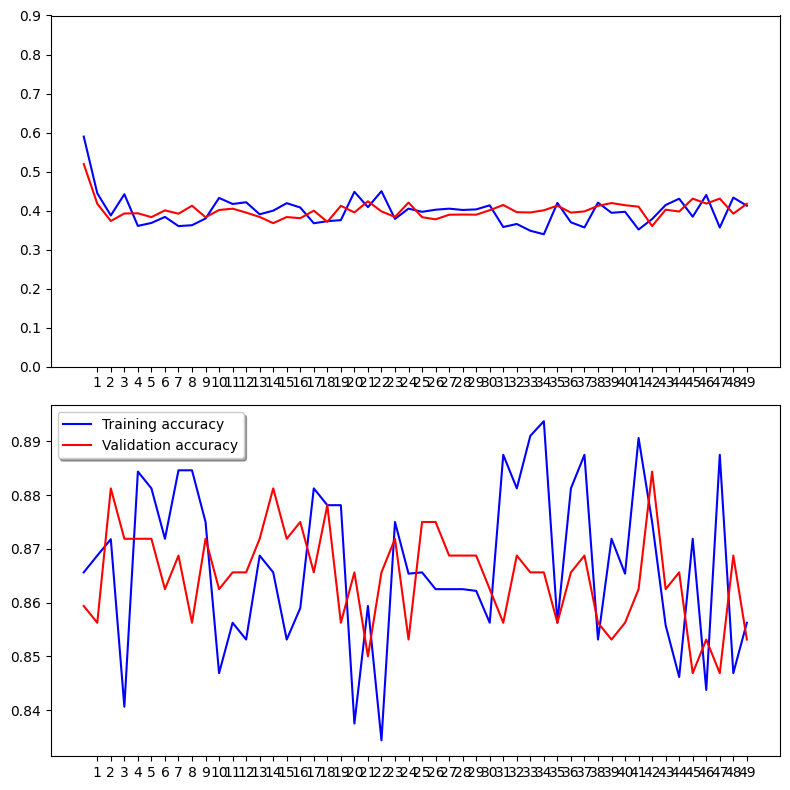

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history_house.history['loss'], color='b', label="Training loss")
ax1.plot(history_house.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history_house.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_house.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

We enconter a problem of over-fitting

In [129]:
housemodel = Sequential()

# Convolution layer
housemodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# housemodel.add(BatchNormalization())
# housemodel.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
housemodel.add(MaxPooling2D())
housemodel.add(Dropout(0.25))

housemodel.add(Conv2D(64, (3, 3), activation='relu'))
# housemodel.add(BatchNormalization())
# housemodel.add(MaxPooling2D(pool_size=(2, 2)))
housemodel.add(MaxPooling2D())
housemodel.add(Dropout(0.25))

housemodel.add(Conv2D(128, (3, 3), activation='relu'))
# housemodel.add(BatchNormalization())
# housemodel.add(MaxPooling2D(pool_size=(2, 2)))
housemodel.add(MaxPooling2D())
housemodel.add(Dropout(0.25))


housemodel.add(Flatten())
housemodel.add(Dense(512, activation='relu'))
# housemodel.add(BatchNormalization())
# housemodel.add(Dropout(0.5))
housemodel.add(Dense(256, activation='relu'))
housemodel.add(Dense(64, activation='relu'))
housemodel.add(Dense(2, activation='softmax')) 

housemodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

housemodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 111, 111, 32)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 54, 54, 64)       

In [130]:
# Try original self-constructed model
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

# Generate the training image
train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_housegenerator = train_idg.flow_from_dataframe(
    train_house, 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

test_idg = ImageDataGenerator(rescale=1./255)

test_housegenerator = test_idg.flow_from_dataframe(
    validate_house, 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_cnn/train_label/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

# Fit the model
epochs=50
history_house2 = housemodel.fit_generator(
    steps_per_epoch=10, 
    generator = train_housegenerator, 
    epochs=epochs,
    validation_data=test_housegenerator,
    validation_steps=10, 
    callbacks=[checkpoint,early]
)


Found 2040 validated image filenames belonging to 2 classes.
Found 510 validated image filenames belonging to 2 classes.
Epoch 1/50


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_5/dense_18/Relu' defined at (most recent call last):
    File "d:\APPdownload\Anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\APPdownload\Anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "d:\APPdownload\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\APPdownload\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "d:\APPdownload\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "d:\APPdownload\Anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "d:\APPdownload\Anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "d:\APPdownload\Anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\APPdownload\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "d:\APPdownload\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "d:\APPdownload\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "d:\APPdownload\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "d:\APPdownload\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "d:\APPdownload\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\APPdownload\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "d:\APPdownload\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "d:\APPdownload\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "d:\APPdownload\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\APPdownload\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "d:\APPdownload\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\FayeLi\AppData\Local\Temp\ipykernel_13816\3478152576.py", line 42, in <module>
      history_house2 = housemodel.fit_generator(
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 2636, in fit_generator
      return self.fit(
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\layers\core\dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "C:\Users\FayeLi\AppData\Roaming\Python\Python39\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_5/dense_18/Relu'
Matrix size-incompatible: In[0]: [32,184832], In[1]: [86528,512]
	 [[{{node sequential_5/dense_18/Relu}}]] [Op:__inference_train_function_27022]

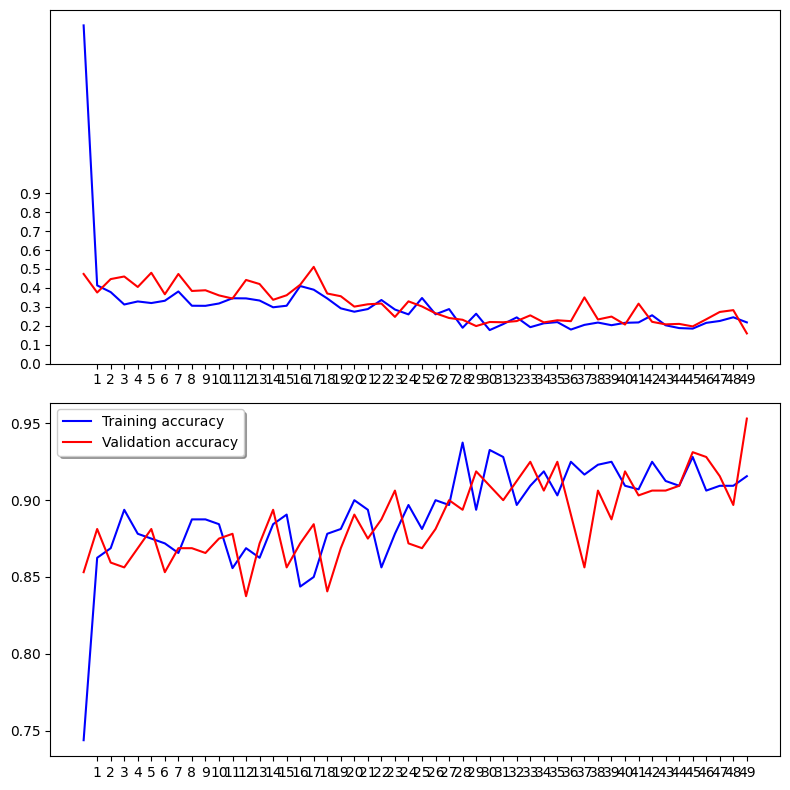

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history_house2.history['loss'], color='b', label="Training loss")
ax1.plot(history_house2.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 50, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history_house2.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history_house2.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 50, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#### Use the selected model to make predictions of house/not-house

Prepare Testing Data

In [131]:
non_labeled = os.listdir("../street_view/street_view/")
test_df = pd.DataFrame({
    'PropertyID': non_labeled
})
num_test = test_df.shape[0]

In [132]:
num_test

16965

In [48]:
IMAGE_WIDTH=320
IMAGE_HEIGHT=320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
batch_size=64

test_gen = ImageDataGenerator(rescale=1./255)
test_housegenerator = test_gen.flow_from_dataframe(
    test_df, 
    "../street_view/street_view/", 
    x_col='PropertyID',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)




Found 16965 validated image filenames.


In [49]:
predict = model.predict_generator(test_housegenerator, steps=np.ceil(num_test/batch_size))

In [50]:
# For categoral classication task, the prediction will give out the probability of each category. We need to pick the category that have the highest probability

test_df['category'] = np.argmax(predict, axis=-1)

# convert the predict category back into generator classes
label_map = dict((v,k) for k,v in train_housegenerator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)



In [57]:
test_df

,PropertyID,category
0,gsv_000024bc-511f-4641-ad3c-56e7dd445526.jpg,house
1,gsv_00035c6a-4ccf-4215-9680-b215fe29cc59.jpg,house
2,gsv_0008ffbb-3089-4b03-806a-2d62da8dc810.jpg,house
3,gsv_00114f24-9677-4337-bf86-a5c4554c7567.jpg,house
4,gsv_001758e2-66d7-49e0-b37c-8db75a504ec9.jpg,house
...,...,...
16960,gsv_ffe34431-cb7c-4011-94a2-f658572fd7d6.jpg,house
16961,gsv_ffee2332-6c00-4a62-a29e-52665c1e54f0.jpg,house
16962,gsv_fff4b546-1af7-4d8c-824f-4eb640c33a26.jpg,house
16963,gsv_fff9212b-cb40-429a-8f81-fe273159a867.jpg,house


<AxesSubplot:>

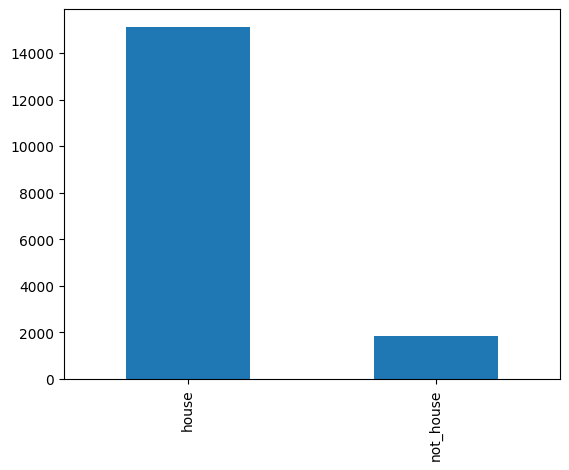

In [56]:
test_df['category'].value_counts().plot.bar()

In [133]:
# convert the test_df to csv
# test_df.to_csv("")

# combine the house/not_house with the properties.csv
housedf = pd.read_csv("../street_view/house_label.csv")
housedf

,Unnamed: 0,property_id,category
0,0,gsv_000024bc-511f-4641-ad3c-56e7dd445526.jpg,house
1,1,gsv_00035c6a-4ccf-4215-9680-b215fe29cc59.jpg,house
2,2,gsv_0008ffbb-3089-4b03-806a-2d62da8dc810.jpg,house
3,3,gsv_00114f24-9677-4337-bf86-a5c4554c7567.jpg,house
4,4,gsv_001758e2-66d7-49e0-b37c-8db75a504ec9.jpg,house
...,...,...,...
16960,16960,gsv_ffe34431-cb7c-4011-94a2-f658572fd7d6.jpg,house
16961,16961,gsv_ffee2332-6c00-4a62-a29e-52665c1e54f0.jpg,house
16962,16962,gsv_fff4b546-1af7-4d8c-824f-4eb640c33a26.jpg,house
16963,16963,gsv_fff9212b-cb40-429a-8f81-fe273159a867.jpg,house


In [134]:
pro_label = pro.merge(housedf, on = 'property_id')
pro_label.head()

,Unnamed: 0_x,address,propertyType,bedrooms,detailUrl,location_lat,location_lng,property_id,Unnamed: 0_y,category
0,0,"12, Gorsey Brigg, Dronfield Woodhouse, Dronfie...",Terraced,3.0,https://www.rightmove.co.uk/house-prices/detai...,53.29986,-1.49446,gsv_60d9dd15-c5a0-4d9c-a341-a1d47add49d5.jpg,6457,house
1,0,"5, Highgate Lane, Dronfield, Derbyshire S18 1UB",Detached,4.0,https://www.rightmove.co.uk/house-prices/detai...,53.29135,-1.45975,gsv_4a586e80-181a-4b82-b5c3-2d789436bb14.jpg,4916,house
2,0,"125, Gosforth Lane, Dronfield, Derbyshire S18 1RB",Detached,3.0,https://www.rightmove.co.uk/house-prices/detai...,53.29763,-1.47573,gsv_93680b6c-237e-44d3-8f40-959a14b80cad.jpg,9778,house
3,0,"80, Shakespeare Crescent, Dronfield, Derbyshir...",Detached,3.0,https://www.rightmove.co.uk/house-prices/detai...,53.29259,-1.45644,gsv_5d49758b-f148-4d06-bbae-3eb23f5c68fb.jpg,6202,house
4,0,"21, Gainsborough Road, Dronfield, Derbyshire S...",Detached,NaN,https://www.rightmove.co.uk/house-prices/detai...,53.29740,-1.48503,gsv_4645f5eb-de7c-474f-8d7e-b59fa8c55f19.jpg,4635,house


In [ ]:
# pro_label_house = pro_label[pro_label.category == 'house']
# train2, test2 = train_test_split(pro_label_house, test_size=0.20, random_state=33)
# train2 = train2.reset_index(drop=True)
# test2 = test2.reset_index(drop=True)

# batch_size=64
# epochs=50

# model = Sequential()

# # Convolution layer
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# # model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# # max pool layer
# model.add(MaxPooling2D())
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# # model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(MaxPooling2D())
# model.add(Dropout(0.25))


# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax')) 

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# model.summary()

# earlystop = EarlyStopping(patience=10)

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.1, 
#                                             min_lr=0.0001)

# callbacks = [earlystop, learning_rate_reduction]

# train_idg = ImageDataGenerator(
#     rotation_range=10, # randomly rotate images
#     rescale=1./255,
#     shear_range=0.1,
#     zoom_range=0.1,  # randomly zoom image 
#     horizontal_flip=True,  # randomly flip images
#     width_shift_range=0.1,  # randomly shift images horizontally
#     height_shift_range=0.1  # randomly shift images vertically
# )

# train_imagegenerator2 = train_idg.flow_from_dataframe(
#     train2, 
#     # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
#     "../street_view/street_view/", 
#     x_col='property_id',
#     y_col='propertyType',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical',
#     batch_size=batch_size
# )

# test_idg = ImageDataGenerator(rescale=1./255)
# test_imagegenerator2 = test_idg.flow_from_dataframe(
#     test2, 
#     # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
#     "../street_view/street_view/", 
#     x_col='property_id',
#     y_col='propertyType',
#     target_size=IMAGE_SIZE,
#     class_mode='categorical',
#     batch_size=batch_size
# )

# history2 = model.fit_generator(
#     train_imagegenerator2, 
#     epochs=epochs,
#     validation_data=test_imagegenerator2,
#     # validation_steps=test_num//batch_size,
#     # steps_per_epoch=train_num//batch_size,
#     callbacks=callbacks
# )

In [135]:
##### 最后如果跑全部数据，可以直接用pro_label就行了，就不需要这个框了

samples1 = os.listdir("../street_view/street_example")
df2 = pd.DataFrame(samples1, columns=['property_id'])

df3 = pd.merge(df2, pro_label[['property_id', 'propertyType', 'category']], on='property_id')
# 只保留房子部分！！
df4 = df3[df3.category == 'house']

train, test = train_test_split(df4, test_size=0.20, random_state=33)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

batch_size=64
epochs=50

model = Sequential()

# Convolution layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
# max pool layer
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(MaxPooling2D())
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax')) 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.1, 
                                            min_lr=0.0001)

callbacks = [earlystop, learning_rate_reduction]

train_idg = ImageDataGenerator(
    rotation_range=10, # randomly rotate images
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,  # randomly zoom image 
    horizontal_flip=True,  # randomly flip images
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1  # randomly shift images vertically
)

train_imagegenerator = train_idg.flow_from_dataframe(
    train, 
    # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example/", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

test_idg = ImageDataGenerator(rescale=1./255)
test_imagegenerator = test_idg.flow_from_dataframe(
    test, 
    # "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_view/", 
    "D:/1999Faye/Postgraduate/Dissertation/p1_SB/street_view/street_example/", 
    x_col='property_id',
    y_col='propertyType',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

history = model.fit_generator(
    train_imagegenerator, 
    epochs=epochs,
    validation_data=test_imagegenerator,
    # validation_steps=test_num//batch_size,
    # steps_per_epoch=train_num//batch_size,
    callbacks=callbacks
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 159, 159, 32)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 159, 159, 32)      0         
                                                                 
 conv2d_40 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 78, 78, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 78, 78, 64)       

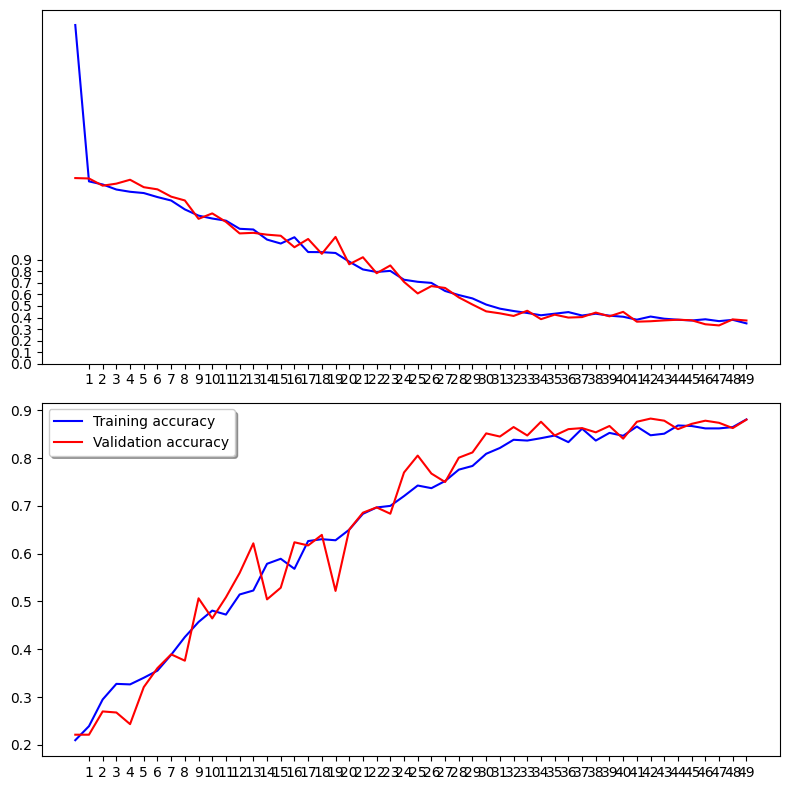

In [136]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#